In [5]:
# Importing all necessary libraries
%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter, OrderedDict

# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# util functions
from util.util import *

# dataset functions
from dataset import load_util

# autoencoder
from models.autoencoder.conv_ae import ConvAE
from models.simclr.IDEC import *
from models.simclr.simclr import *
from models.simclr.transforms import *
from cluster_accuracy import cluster_accuracy

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
print("Versions:")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"numpy: {np.__version__}",)
print(f"scikit-learn: {sklearn.__version__}")

device = detect_device()
print("Using device: ", device)

Versions:
torch: 1.8.1+cu111
torchvision: 0.9.1+cu111
numpy: 1.19.5
scikit-learn: 0.24.1
Using device:  cuda


In [8]:
# specify learning params
batch_size = 264
learning_rate = 1e-3
epochs = 150

# training

train = True

# load datasets and create dataloaders
data, testdata = load_util.load_cifar('./data', download=True, for_model='SimCLR')
data_percent = 0.4

Files already downloaded and verified


### Clustering and PCA of the Random SimCLR model (already discussed, I have left this part in case you would like to compare resnet50 to resnet18

In [9]:
test_data = load_util.load_custom_cifar('./data', download=False, for_model='SimCLR', train=False, data_percent=1.0, transforms=False)
testloader = torch.utils.data.DataLoader(test_data,
                                          batch_size=264,
                                          shuffle=True,
                                          drop_last=True)

In [10]:
colors_classes = {i: color_class for i, color_class in zip(range(len(test_data.classes)), test_data.classes)}

In [49]:
nmis = {}
pcas = {}
lcs = {}

In [ ]:
names = ['pretrained_SimCLR_r18_200', 'IDEC_SimCLR_r18_e100', 'IDEC_SimCLR_r18_e200', 'IDEC_SimCLR_r18_e300']
for name in names:
    model = load_model(name + '.pth', device)
    _, _, nmi, pca, lable_classes = compute_nmi_and_pca(rotnet,
                                                        name,
                                                        colors_classes,
                                                        device,
                                                        testloader)
    nmis[name] = nmi
    pcas[name] = pca
    lcs[name] = lable_classes

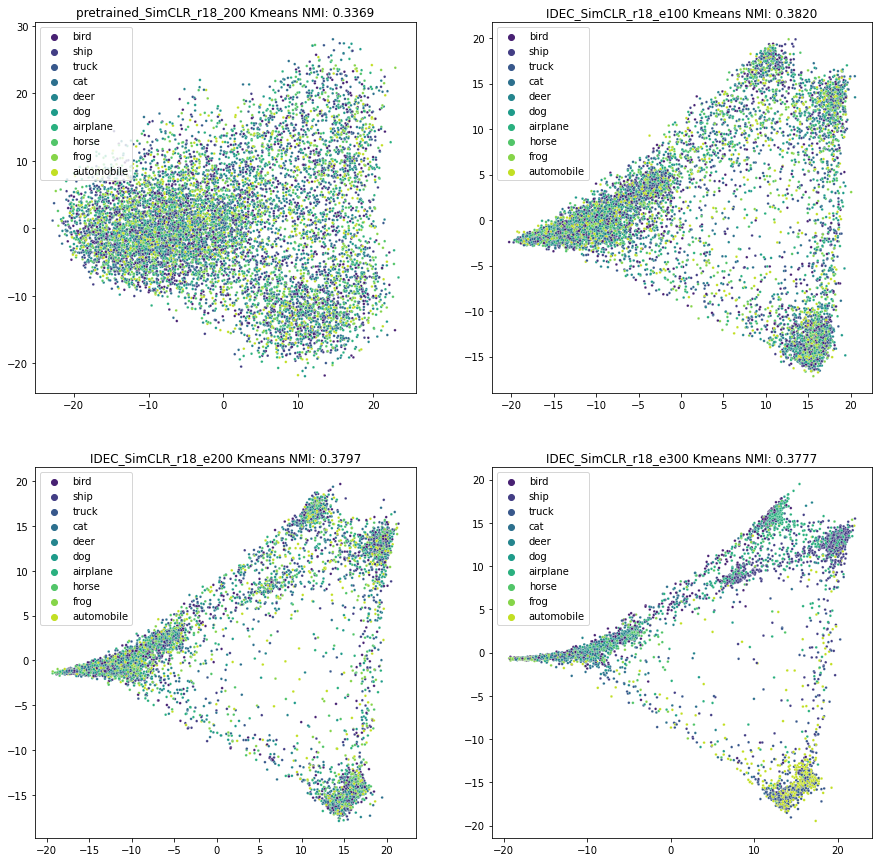

In [18]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()

for i, ver in enumerate(nmis.keys()):
    axes[i].set_title(f'{ver} Kmeans NMI: {nmis[ver]:.4f}')
    sns.scatterplot(ax=axes[i], x=pcas[ver][:,0], y=pcas[ver][:,1], hue=lcs[name], s=7, palette='viridis')  

pretrained_SimCLR_r18_200 class representation


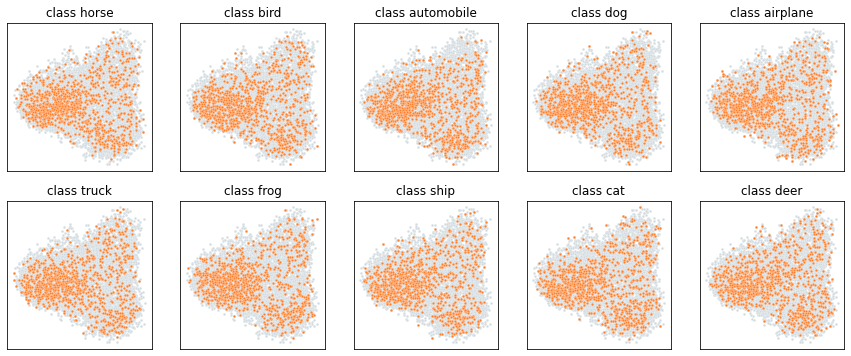

IDEC_SimCLR_r18_e100 class representation


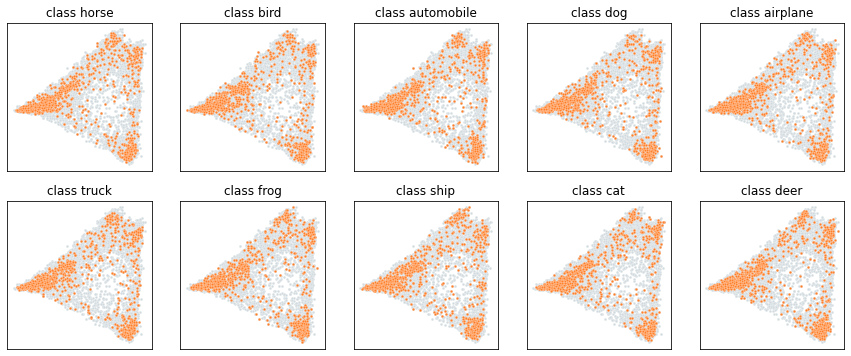

IDEC_SimCLR_r18_e200 class representation


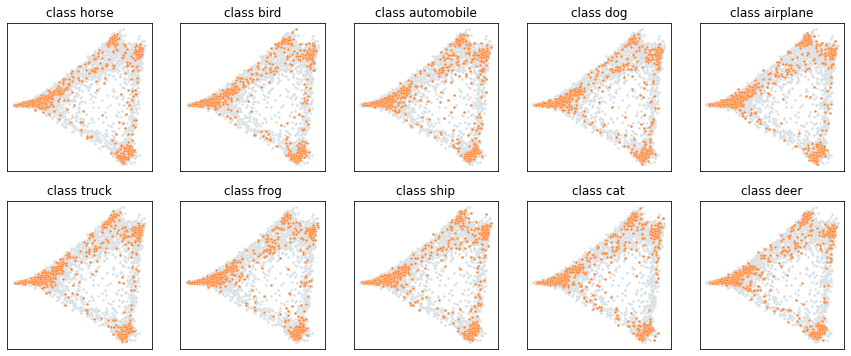

IDEC_SimCLR_r18_e300 class representation


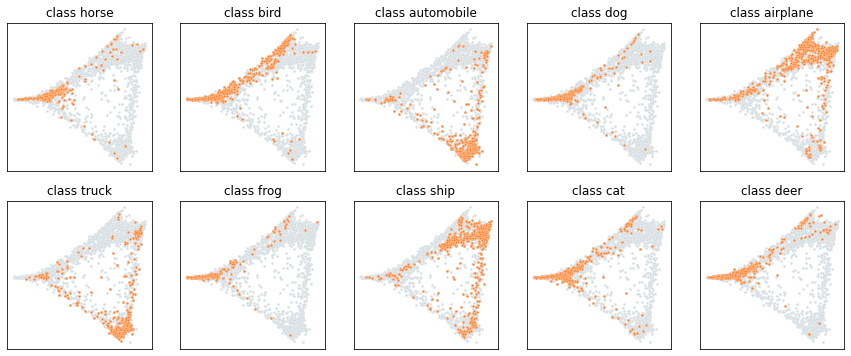

In [21]:
for name in nmis.keys():
    plot_class_representation(pcas[name], name, lable_classes)

The representation definetely gets better after training with IDEC. "Noise" from the middle slowly moves toward cluster centers. Classifications (and the errors in the classification) make sense: auto and truck are in the same cluster, birds are classified somewhere between airplane and "animals". Animal classifications differ slightly but all of them kinda go to the left "corner".
I think the problem is that pretrained data representation is not optimal, it seems the net did not really learn more detailed differences. My guess is that if I train with ResNet50 as a base and on the whole dataset, the pretrained representation should get better result (because SimCLR relies on comparison between images and bigger batches)

## SimCLR Resnet 50: Pretraining

In [10]:
name = 'pretrained_SimCLR_r50_e500.pth'
compute_nmi_and_pca(name, color_classes)

pretrained_SimCLR_r50_e500.pth
Starting encoding...
Starting KMeans...
Starting PCA...


<AxesSubplot:title={'center':'pretrained_SimCLR_r50_e500.pth Kmeans NMI: 0.4098'}>

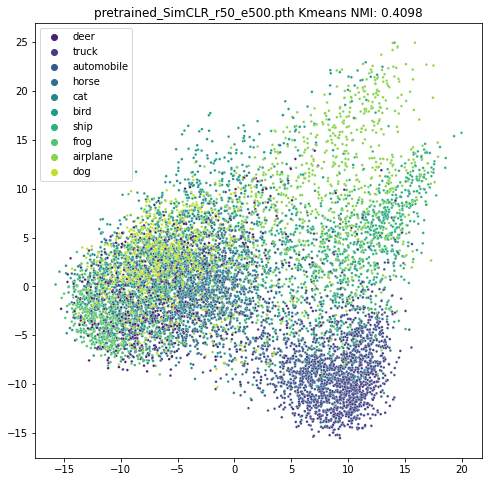

In [13]:
lc = np.array(lable_classes)
fig, axes = plt.subplots(figsize=(8,8))

axes.set_title(f'{name} Kmeans NMI: {nmis[name]:.4f}')
sns.scatterplot(ax=axes, x=pcas[name][:,0], y=pcas[name][:,1], hue=lable_classes, s=7, palette='viridis') 

pretrained_SimCLR_r50_e500.pth class representation


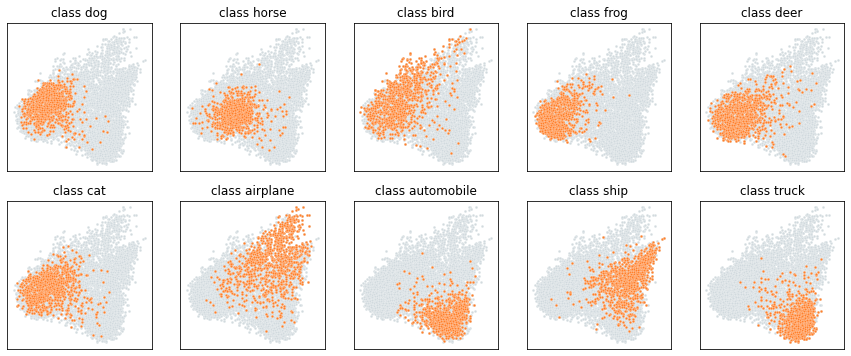

In [14]:
plot_class_representation(pca, name, lable_classes)

## IDEC ResNet50 Summary

In [7]:
nmis = {}
pcas = {}
lcs = {}

In [15]:
names = ['pretrained_SimCLR_r50_e1000.pth',
         'IDEC_SimCLR_r50_e1000_ei200.pth',
         'IDEC_SimCLR_r50_e500_ie200_c30.pth',
         'IDEC_SimCLR_r50_e500_ie200_c30_e100_c10.pth']

In [9]:
for name in names:
    model = load_model(name, device)
    labels, kmeans, nmi, pca, lable_classes = compute_nmi_and_pca(model, name, colors_classes, device, testloader)
    nmis[name] = nmi
    pcas[name] = pca
    lcs[name] = lable_classes

D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)
D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)
D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torc

Note on names: e500 means pretraining with 500 epochs, ie200 means training IDEC training with 200 epochs, c30 means IDEC with 30 clusters, etc.

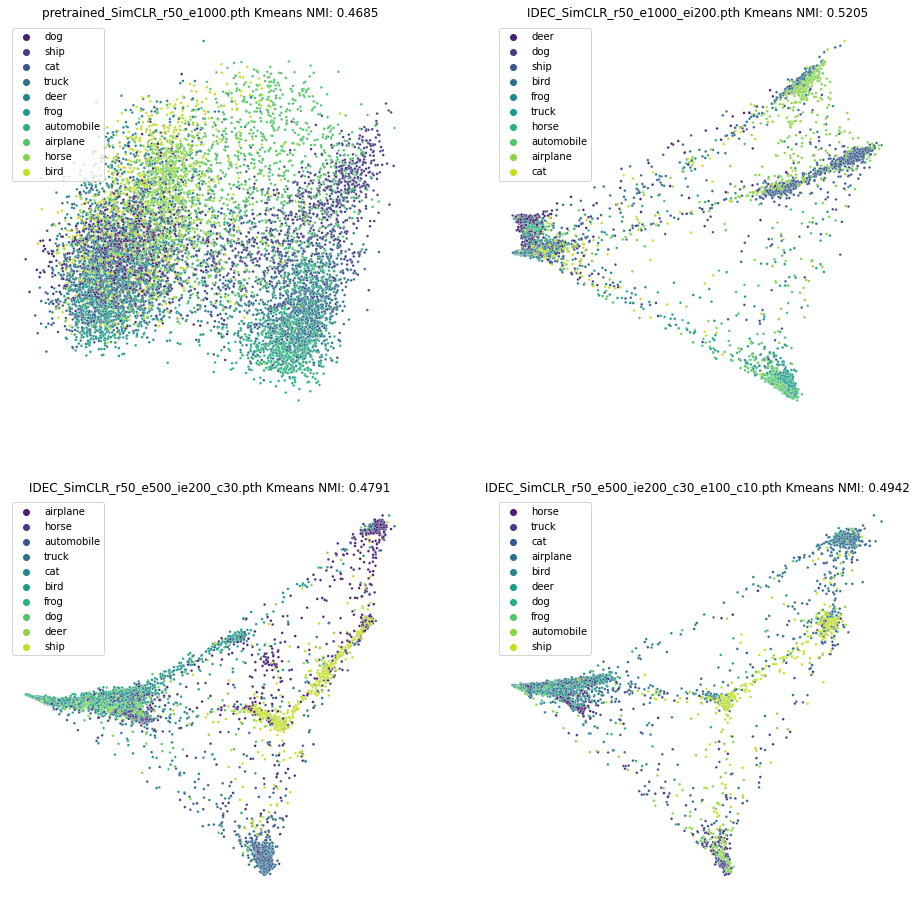

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16,16))
axes = axes.flatten()

for i, name in enumerate(names):
    plot_pca_and_nmi(name, axes[i], nmis[name], pcas[name], lcs[name])

Unfortunately when generating final summary I have noticed that another couple of KMeans and PCA provided different results: NMI of SimCLR pretraining with 1000 epochs has suddenly achieved much better NMI. Now it seems to me that the IDEC's improved accuracy just lies in longer training. But performing clustering with bigger number of clusters has helped, but not significantly: instead of 4 clusters we now have five, but they still don't correspond to the "true" clusters.

Because I understood that SimCLR did not reach it limits, I also tried to train IDEC further with 1000-epochs pretrained state. But although the accuracy has improved further, I think it still does not work very well because the model did not really learn the difference between some of the classes. All classes are still evenly distributed between the clusters.

pretrained_SimCLR_r50_e1000.pth class representation


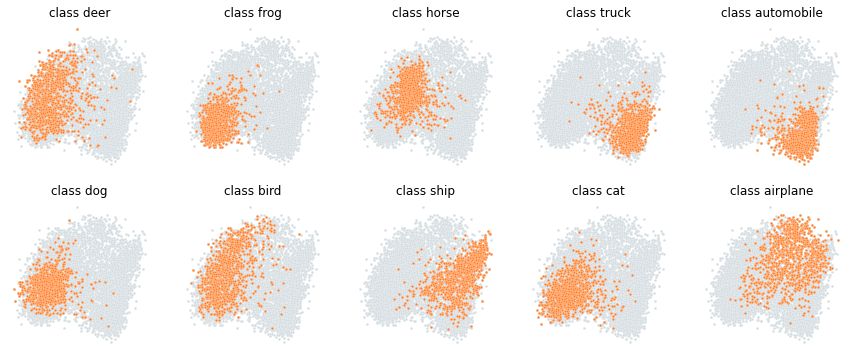

IDEC_SimCLR_r50_e1000_ei200.pth class representation


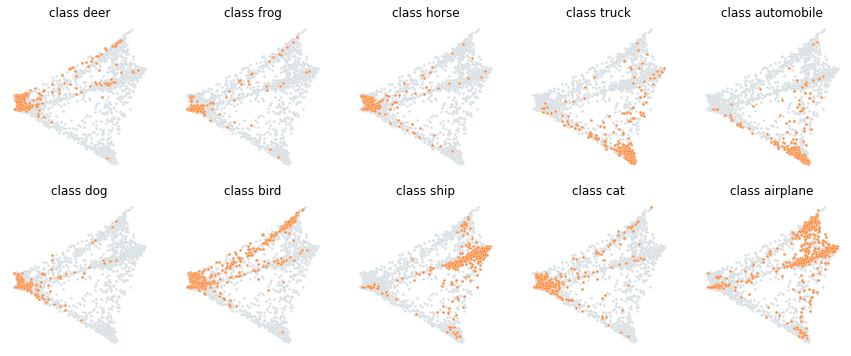

IDEC_SimCLR_r50_e500_ie200_c30.pth class representation


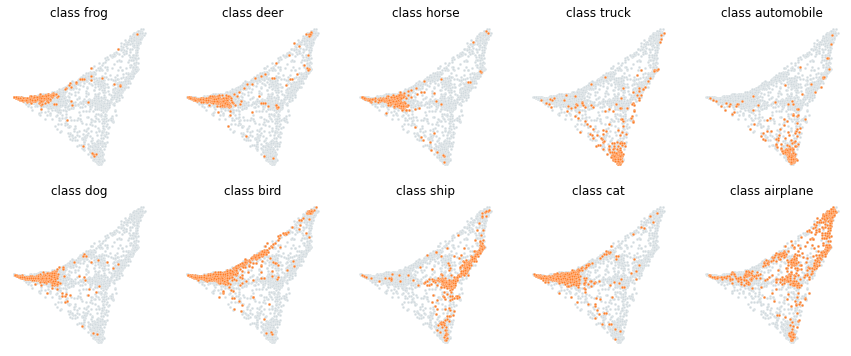

IDEC_SimCLR_r50_e500_ie200_c30_e100_c10.pth class representation


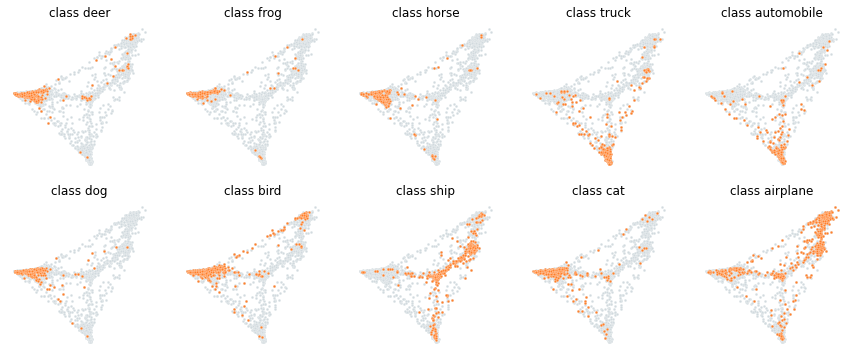

In [20]:
for i, name in enumerate(names):
    plot_class_representation(pcas[name], name, lcs[name])

## Cluster Accuracy and Confusion Matrix

In [106]:
names = ['pretrained_SimCLR_r50_e1000.pth', 'IDEC_SimCLR_r50_e1000_ei200.pth']

pretrained_SimCLR_r50_e1000.pth
Starting encoding...
Starting KMeans...
Starting PCA...


D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


IDEC_SimCLR_r50_e1000_ei200.pth
Starting encoding...
Starting KMeans...
Starting PCA...


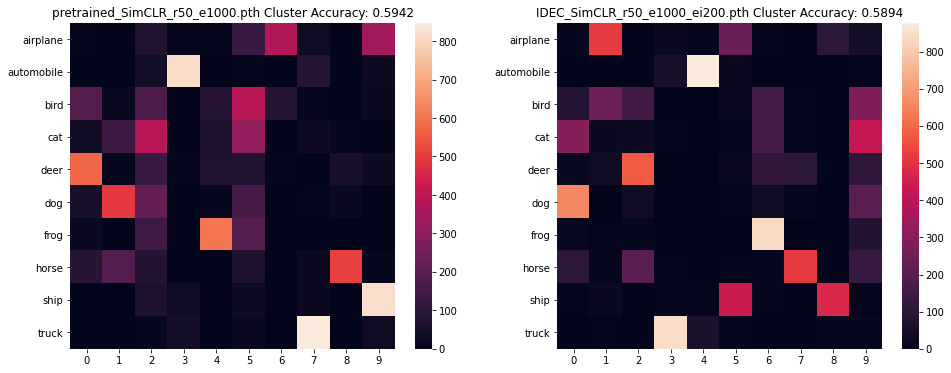

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes = axes.flatten()

for i, name in enumerate(names):
    model = load_model(name, device)
    labels, kmeans, _, _, lable_classes = compute_nmi_and_pca(model, name, colors_classes, device, testloader)
    simclr_ca = cluster_accuracy(labels, kmeans.labels_)
    cm = confusion_matrix(labels, kmeans.labels_, labels=list(range(len(test_data.classes))), normalize=None)
    axes[i].set(title=f'{name} Cluster Accuracy: {simclr_ca:.4f}')
    sns.heatmap(cm, yticklabels=test_data.classes, ax=axes[i])

The cluster accuracy is much better than original DEC cluster accuracy (30.1 according to the paper you've sent), but unfortunately one can see that the DEC does not really improve the results of pretraining.

## DEC SimCLR

After your note in the last e-mail that you actually wanted to train all the models just with a DEC clustering loss, and not a combination of the original and cluster closses, I retrained the SimCLR only with the DEC clustering loss.

In [90]:
names = ['DEC_SimCLR_e1000_de10.pth', 'DEC_SimCLR_e1000_de100.pth']

DEC_SimCLR_e1000_de10.pth
Starting encoding...
Starting KMeans...
Starting PCA...


D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


DEC_SimCLR_e1000_de100.pth
Starting encoding...
Starting KMeans...
Starting PCA...


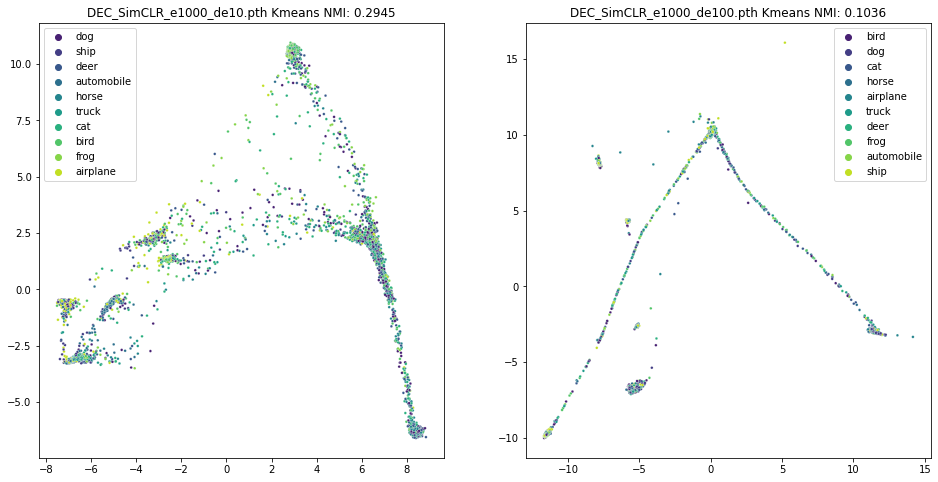

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes = axes.flatten()

for i, name in enumerate(names):
    model = load_model(name, device)
    labels, kmeans, nmi, pca, lable_classes = compute_nmi_and_pca(model, name, colors_classes, device, testloader)
    plot_pca_and_nmi(name, axes[i], nmi, pca, lable_classes)

The result is pretty bad: all the points are projected on the sides of a pyramid and the longer the training is, the worse KMeans results are. But the form of the structure reminded me of the result of the RotNet's clustering with Adam optimizer which resulted in the "cube" clustering. So I decided to train SimCLR DEC with only clustering loss and SDG optimizer.

## DEC SimCLR with SDG Optimizer

DEC result with SDG optimizer looks much better than with the Adam optimizer and resembles the result of the RotNet's DEC clustering a lot. I have an idea to try to pretrain SimCLR with a SDG optimizer instead of the Adam, too, and see if it yields better results, but I haven't tested it out yet.

In [8]:
name = 'DEC_SimCLR_r50_e1000_sdg30.pth'
model = load_model(name, device)
labels, kmeans, nmi, pca, lable_classes = compute_nmi_and_pca(model, name, colors_classes, device, testloader)

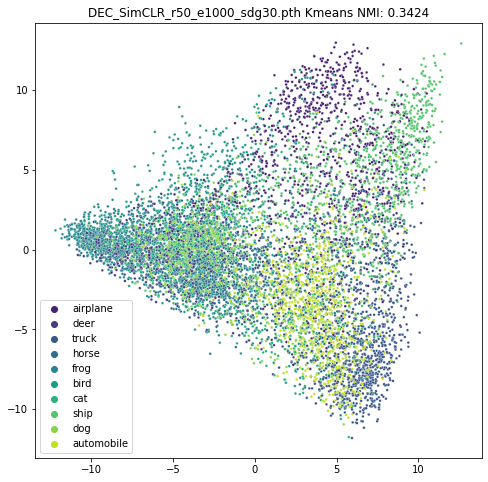

In [11]:
fig, axes = plt.subplots(figsize=(8, 8))
plot_pca_and_nmi(name, axes, nmi, pca, lable_classes)

DEC_SimCLR_r50_e1000_sdg30.pth class representation


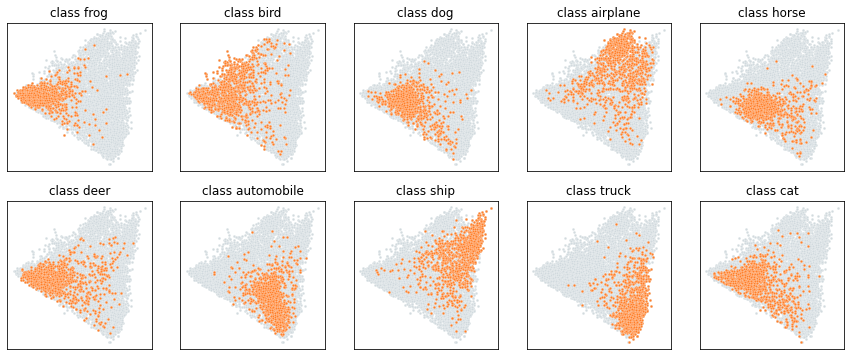

In [12]:
plot_class_representation(pca, name, lable_classes)

<AxesSubplot:title={'center':'DEC_SimCLR_r50_e1000_sdg30.pth Cluster Accuracy: 0.4642'}>

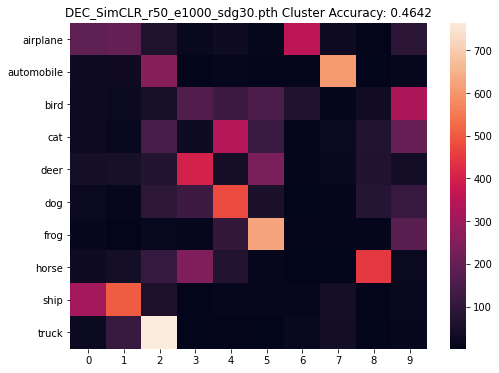

In [15]:
fig, axes = plt.subplots(figsize=(8, 6))

simclr_ca = cluster_accuracy(labels, kmeans.labels_)
cm = confusion_matrix(labels, kmeans.labels_, labels=list(range(len(test_data.classes))), normalize=None)
axes.set(title=f'{name} Cluster Accuracy: {simclr_ca:.4f}')
sns.heatmap(cm, yticklabels=test_data.classes, ax=axes)

## SimCLR IDEC: Degree of space distortion

In [21]:
test_data = load_util.load_custom_cifar('./data', download=False, for_model='SimCLR', train=False, data_percent=1.0, transforms=False)
testloader = torch.utils.data.DataLoader(test_data,
                                          batch_size=264,
                                          shuffle=True,
                                          drop_last=True)

In [22]:
colors_classes = {i: color_class for i, color_class in zip(range(len(test_data.classes)), test_data.classes)}

Note: clustering loss is around 2, SimCLR loss is around 4-5, so when degree of space distortion is 0.1, clustering loss is 20 times less than SimCLR loss.

In [23]:
degrees = [0.1, 0.5, 1.0, 1.5]

In [24]:
pcas = {}
nmis = {}
lcs = {}
cas = {}
cms = {}

In [26]:
for i, d in enumerate(degrees):
    e = 100 if d != 0.1 else 200
    name = f'IDEC_SimCLR_d{d}_e{e}.pth'
    model = load_model(name, device)
    labels, kmeans, nmi, pca, lable_classes = compute_nmi_and_pca(model, name, colors_classes, device, testloader)
    
    nmis[name] = nmi
    pcas[name] = pca
    lcs[name] = lable_classes
    cas[name] = cluster_accuracy(labels, kmeans.labels_)
    cms[name] = confusion_matrix(labels, kmeans.labels_, labels=list(range(len(test_data.classes))), normalize=None)

D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)
D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)
D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torc

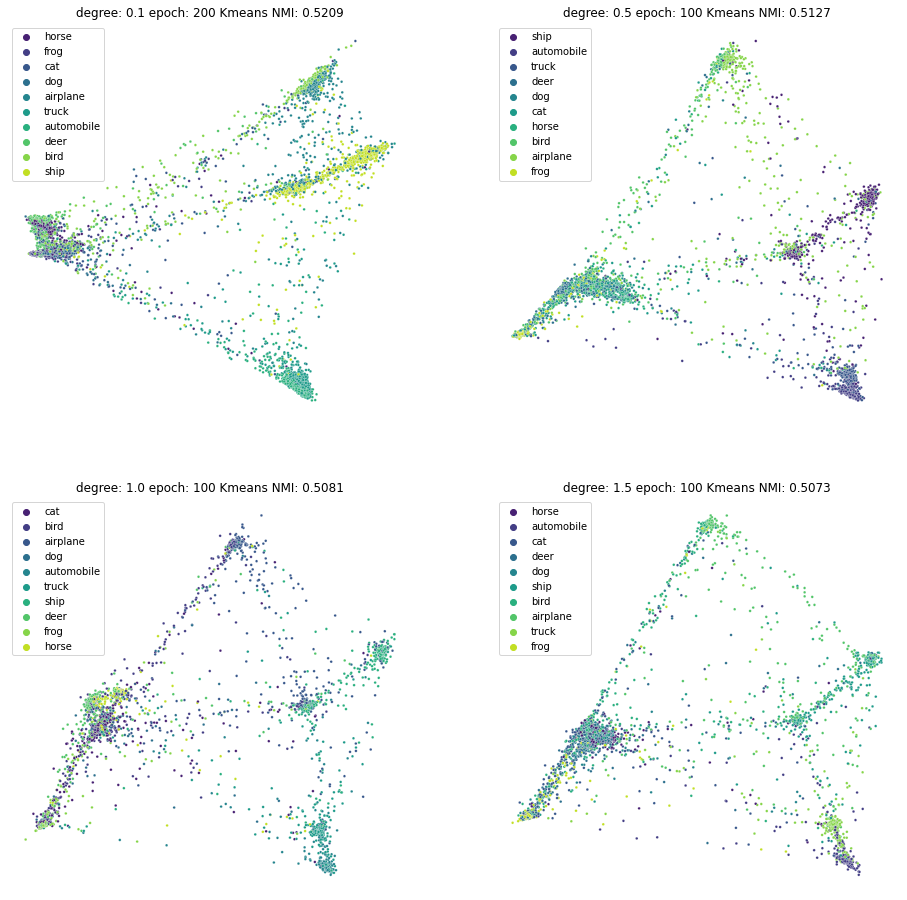

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

for i, d in enumerate(degrees):
    e = 100 if d != 0.1 else 200
    name = f'IDEC_SimCLR_d{d}_e{e}.pth'
    plot_pca_and_nmi(f'degree: {d} epoch: {e}', axes[i], nmis[name], pcas[name], lcs[name])

This approach makes NMI better. In comparison, NMI of SimCLR pretrained for 1000 epochs is around 0.47, and here NMI after training with 100 epochs is around 0.51. I have noticed that I had an error in the plot for SimCLR ResNet 50 Summary, so I regenerated it. It is better if you look at the clusters of ResNet 50 Summary again.

The epoch number for 0.1 degree is different since I just took the old results, the comparison of degree 0.5 and 0.1 where both are 200 epochs follows later.

Degree of space distortion: 0.1 Epoch: 200 class representation


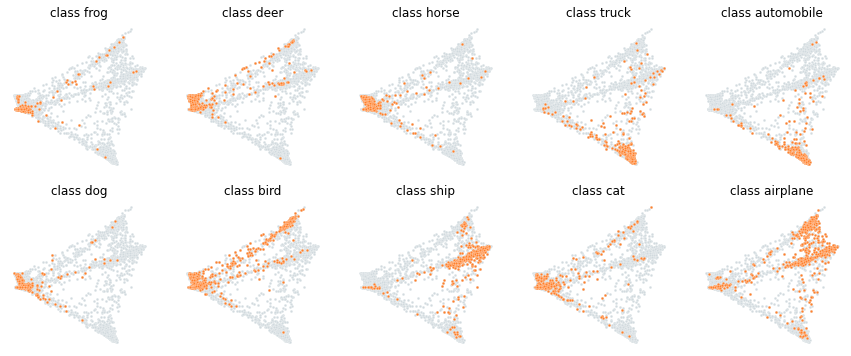

Degree of space distortion: 0.5 Epoch: 100 class representation


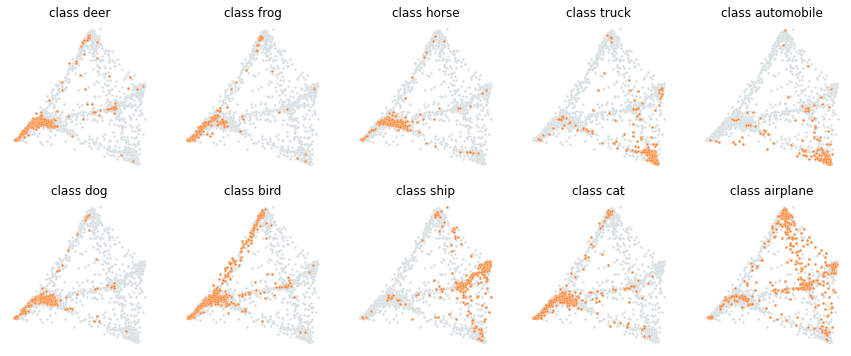

Degree of space distortion: 1.0 Epoch: 100 class representation


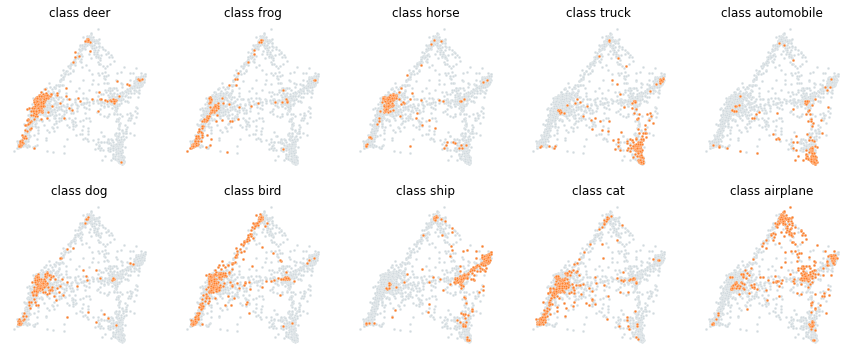

Degree of space distortion: 1.5 Epoch: 100 class representation


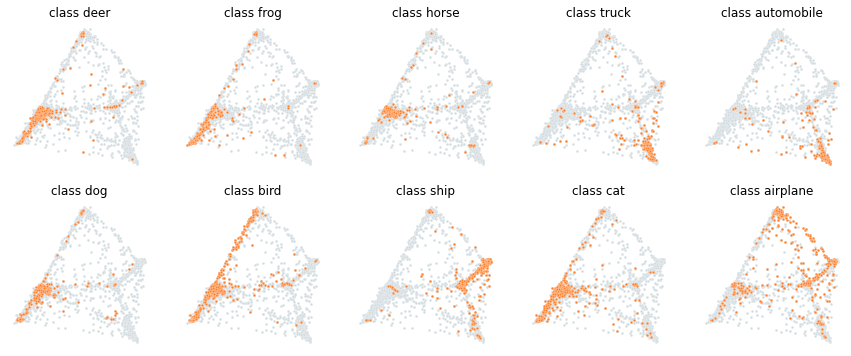

In [32]:
for i, d in enumerate(degrees):
    e = 100 if d != 0.1 else 200
    name = f'IDEC_SimCLR_d{d}_e{e}.pth'
    plot_class_representation(pcas[name], f'Degree of space distortion: {d} Epoch: {e}', lcs[name])

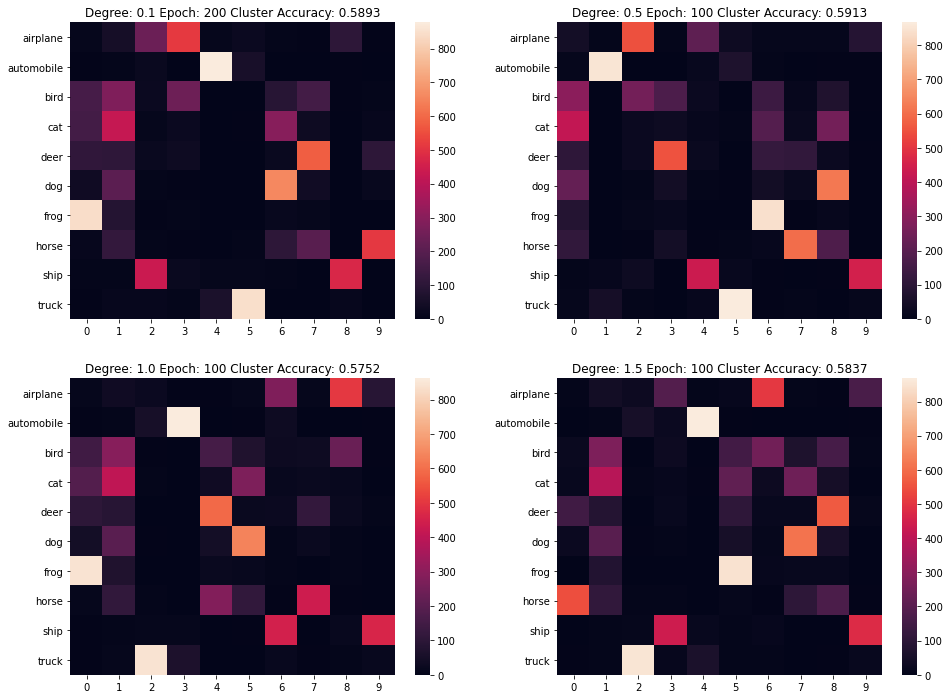

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, d in enumerate(degrees):
    e = 100 if d != 0.1 else 200
    name = f'IDEC_SimCLR_d{d}_e{e}.pth'
    axes[i].set(title=f'Degree: {d} Epoch: {e} Cluster Accuracy: {cas[name]:.4f}')
    sns.heatmap(cms[name], yticklabels=test_data.classes, ax=axes[i])

### Comparison between 0.1 and 0.5 degrees of space distortion

In [34]:
names = ['IDEC_SimCLR_d0.5_e100.pth', 'IDEC_SimCLR_d0.5_e200.pth', 'IDEC_SimCLR_d0.1_e200.pth']
pcas = {}
nmis = {}
lcs = {}
cas = {}
cms = {}

In [36]:
for i, name in enumerate(names):
    model = load_model(name, device)
    labels, kmeans, nmi, pca, lable_classes = compute_nmi_and_pca(model, name, colors_classes, device, testloader)
    
    nmis[name] = nmi
    pcas[name] = pca
    lcs[name] = lable_classes
    cas[name] = cluster_accuracy(labels, kmeans.labels_)
    cms[name] = confusion_matrix(labels, kmeans.labels_, labels=list(range(len(test_data.classes))), normalize=None)

D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)
D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)
D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torc

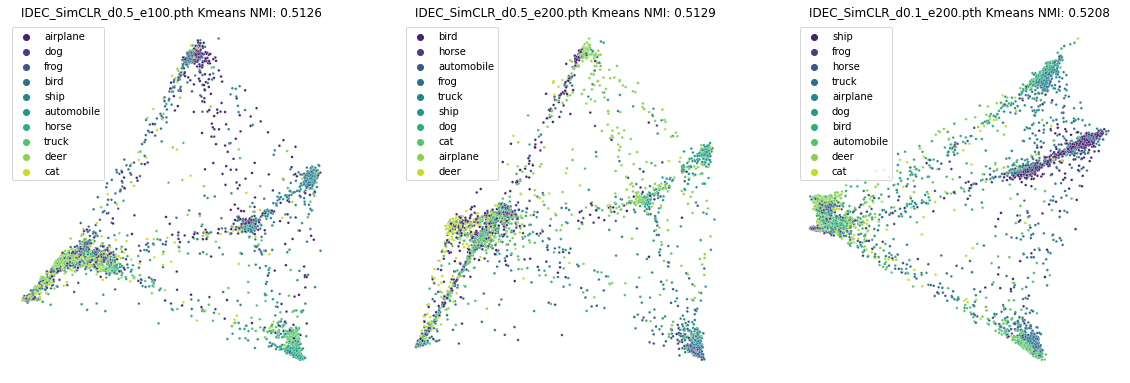

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6.5))
axes = axes.flatten()

for i, name in enumerate(names):
    plot_pca_and_nmi(name, axes[i], nmis[name], pcas[name], lcs[name])

IDEC_SimCLR_d0.5_e100.pth class representation


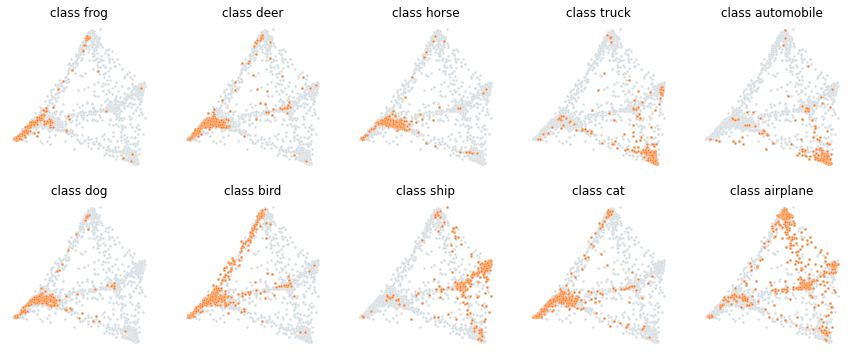

IDEC_SimCLR_d0.5_e200.pth class representation


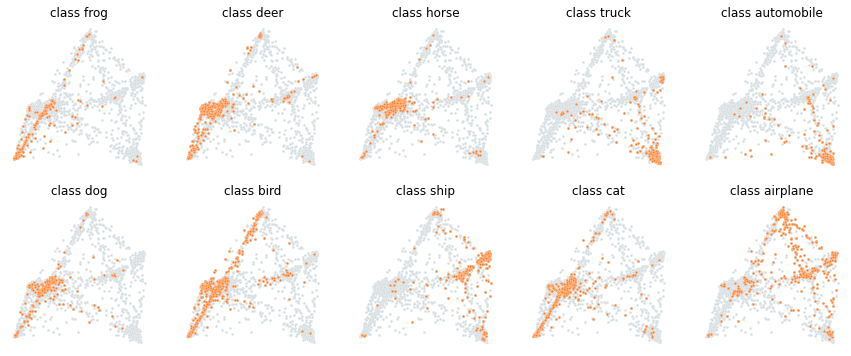

IDEC_SimCLR_d0.1_e200.pth class representation


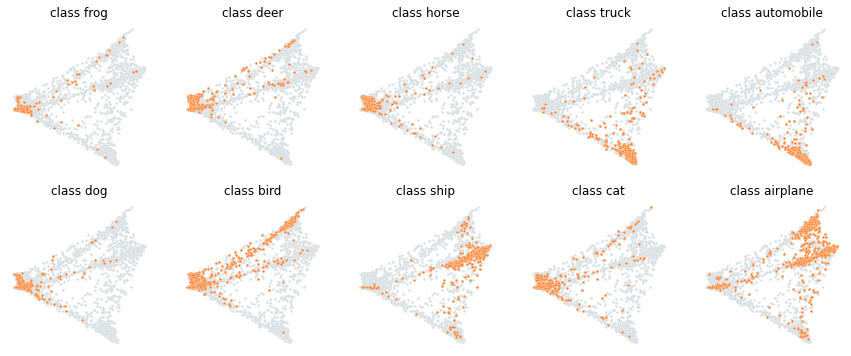

In [39]:
for i, name in enumerate(names):
    plot_class_representation(pcas[name], name, lcs[name])

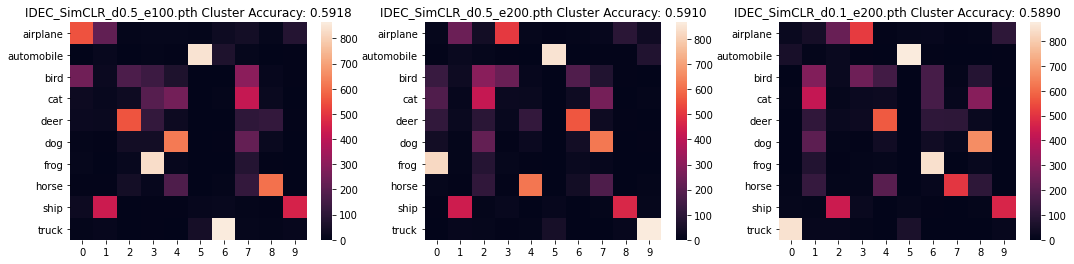

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes = axes.flatten()

for i, name in enumerate(names):
    axes[i].set(title=f'{name} Cluster Accuracy: {cas[name]:.4f}')
    sns.heatmap(cms[name], yticklabels=test_data.classes, ax=axes[i])

As we can see from comparison of plots and metrics for degree of space distortion 0.5, training with IDEC does not really bring anything if trained more than 100 epochs.

Note: clustering accuracy of the SimCLR pretrained for 1000 epochs is also around 58. So the cluster accuracy still won't be improved also with the bigger degree of space distortion.

Summary: IDEC improves NMI (+5%), but not clustering accuracy (stays the same), but I am not sure whether the impovement of the NMI comes from longer SimCLR training or from using IDEC.

## SimCLR with Augmented DEC (Degree of space distortion = 0.5)

In [11]:
name = 'IDEC_SimCLR_aug_e100.pth'

In [12]:
model = load_model(name, device)

/Users/godlinn/Documents/Studium/WS2020/Bachelor/DeepClusteringLoss/models/dec/DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


In [13]:
labels, kmeans, nmi, pca, lable_classes = compute_nmi_and_pca(model, name, colors_classes, device, testloader)

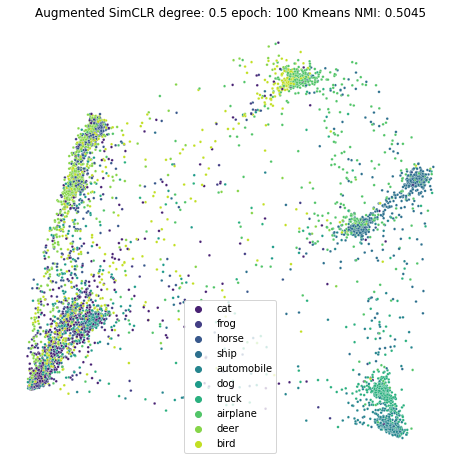

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
plot_pca_and_nmi(f'Augmented SimCLR degree: {0.5} epoch: {100}', axes, nmi, pca, lable_classes)

IDEC_SimCLR_aug_e100.pth class representation


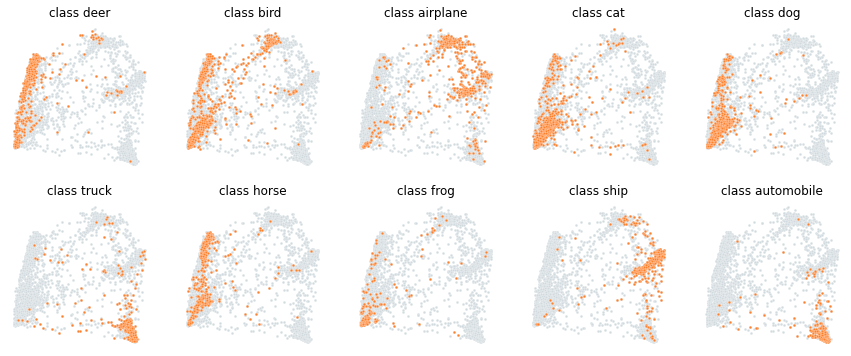

In [16]:
plot_class_representation(pca, name, lable_classes)

<AxesSubplot:title={'center':'IDEC_SimCLR_aug_e100.pth Cluster Accuracy: 0.5603'}>

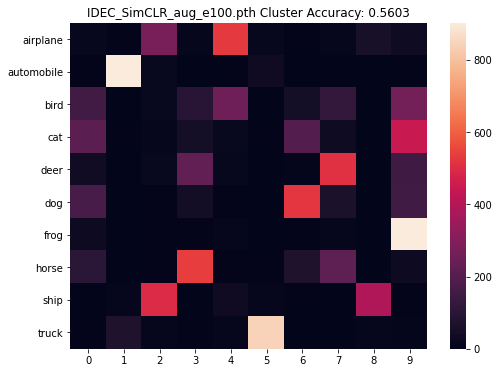

In [17]:
fig, axes = plt.subplots(figsize=(8, 6))

ca = cluster_accuracy(labels, kmeans.labels_)
cm = confusion_matrix(labels, kmeans.labels_, labels=list(range(len(test_data.classes))), normalize=None)
axes.set(title=f'{name} Cluster Accuracy: {ca:.4f}')
sns.heatmap(cm, yticklabels=test_data.classes, ax=axes)

Questions:
- Train IDEC with aug or non-aug DEC? Non-aug
- Train for 500 epochs max? Training on full dataset takes much longer than on 40%, 900 epochs will probably take a week (? also see next question). 400 pretraining + 100 IDEC
- Bottlenecks when training multiple models simultaneously? 130 epochs in 6h when training alone, now 20 epochs per 12h
- How much of the uni server resources can I take? Now 40% of memory in each of the GPUs

In [23]:
from models.rotnet.custom_stl10 import RotNetSTL10
from models.rotnet.rotnet import RotNet

In [27]:
stl10 = RotNetSTL10()
dataloader = torch.utils.data.DataLoader(stl10,
                                         batch_size=128,
                                         shuffle=True,
                                         drop_last=True)

In [25]:
model = RotNet(num_classes=4)

In [26]:
model.name = f'{model.name}_STL10_0'

In [ ]:
train_model(model, 128, 0.1, 100, dataloader, True, device, degree_of_space_distortion=None):

In [28]:
def train_model(model, batch_size, learning_rate, epochs, data, train, device, degree_of_space_distortion=None):
    print(f"Training {model.name} started...")
    model.to(device)

    # paths to save/load models from
    base_path = "trained_models"
    pretrained_model_name = f"pretrained_{model.name}.pth"
    pretrained_model_path = os.path.join(base_path, pretrained_model_name)

    # training
    if train:

#         trainloader = torch.utils.data.DataLoader(data,
#                                                   batch_size=batch_size,
#                                                   shuffle=True,
#                                                   drop_last=True)
        trainloader = data

        if degree_of_space_distortion is None:
            model = model.fit(data_loader=trainloader, epochs=epochs, start_lr=learning_rate, device=device,
                              model_path=pretrained_model_path)
        else:
            model = model.fit(data_loader=trainloader, epochs=epochs, start_lr=learning_rate, device=device,
                              model_path=pretrained_model_path, degree_of_space_distortion=degree_of_space_distortion)
        torch.save(model.state_dict(), pretrained_model_path)
    else:
        state_dict = torch.load(pretrained_model_path, map_location=device)
        model.load_state_dict(state_dict)

    return model